In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras import regularizers
from keras import backend as K
from tensorflow.keras import layers

print(tf.__version__)

Using TensorFlow backend.
2.1.0


In [4]:
dataset = pd.read_csv('well_1_60.csv',na_values=-9999.99)
#dataset = dataset[:7516]       #well_1

### delete all rows containing null values (-9999.99)

In [30]:
dataset.isna().sum()

For                             0
Date & Time                     0
Depth: TMD                      0
Bit Position                    0
Hook Position                   0
WOH Max                         0
WOH Avg                         0
WOH Min                         0
WOB Max                         0
WOB Avg                         0
WOB Min                         0
Torque Max                      0
Torque Avg                      0
Torque Min                      0
Pressure: SPP Max               0
Pressure: SPP Avg               0
Pressure: SPP Min               0
RPM Avg                         0
ROP_AVG                         0
ROP (Time)                      0
Flow In Pumps Avg               0
Flow Paddle                     0
Mud:Temperature IN Avg       6872
Mud: Temperature OUT Avg        0
Pits: Total Active Volume       0
delta_depth                     0
delta_time                      0
cum_delta_depth                 0
cum_delta_time                  0
ROP_inst_cal  

In [31]:
dataset = dataset.dropna()

In [43]:
dataset['Depth'] = dataset['Depth: TMD']
dataset.pop('Depth: TMD')
dataset.columns

Index(['For', 'Date & Time', 'Bit Position', 'Hook Position', 'WOH Max',
       'WOH Avg', 'WOH Min', 'WOB Max', 'WOB Avg', 'WOB Min', 'Torque Max',
       'Torque Avg', 'Torque Min', 'Pressure: SPP Max', 'Pressure: SPP Avg',
       'Pressure: SPP Min', 'RPM Avg', 'ROP_AVG', 'ROP (Time)',
       'Flow In Pumps Avg', 'Flow Paddle', 'Mud:Temperature IN Avg',
       'Mud: Temperature OUT Avg', 'Pits: Total Active Volume', 'delta_depth',
       'delta_time', 'cum_delta_depth', 'cum_delta_time', 'ROP_inst_cal',
       'adj_MSE', 'std_delta_torque', 'std_torque_AVG', 'std_WOB_avg',
       'std_RPM_avg', 'std Torque_max', 'std Torque_min', 'Depth'],
      dtype='object')

In [34]:
def norm(x,d):
    return 2*(x-d['min'])/(d['max']-d['min']) -1

In [54]:
to_remove = ['ROP_AVG','ROP (Time)']
rop = "ROP_inst_cal"
validation = 0.2
training = 0.8
history = None
annotations = [dict(xref='paper', yref='paper', x=0.0, y=1.05,
                        xanchor='left', yanchor='bottom',
                        text='ROP prediction',
                        font=dict(family='Arial',
                                  size=30,
                                  color='rgb(37,37,37)'),
                        showarrow=False)]

def graph(test_rop, test_predictions):
    a = plt.axes(aspect='equal')
    plt.scatter(test_rop, test_predictions, color='blue')
    plt.xlabel('True Values [ROP]')
    plt.ylabel('Predictions [ROP]')
    lims = [-10, 120]
    plt.xlim(lims)
    plt.ylim(lims)
    return plt.plot(lims, lims ,color='red')


def get_optimizer(N_TRAIN):
    BATCH_SIZE = 1879
    STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.003,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=0.9,
    staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)


def build_model(lenth,hidden,layer,data_len):
    #init = keras.initializers.RandomUniform(minval=-1, maxval=1, seed=None) #'he_normal' / tf.keras.initializers.GlorotNormal()
    activation = tf.keras.layers.LeakyReLU() #'elu' 
    #optimizer = get_optimizer(data_len)
    #optimizer = tf.keras.optimizers.RMSprop()
    optimizer = tf.keras.optimizers.Adam(0.001)
    #optimizer = tfa.optimizers.AdamW(0.001)
    model = None
    regularizer = regularizers.l2(0.01)
    #init = tf.keras.initializers.GlorotNormal()
    init = 'he_normal' 
    activation = 'relu'

    if layer == 5:
        model = keras.Sequential([
            layers.Dense(hidden, activation= activation,kernel_initializer=init,
                    kernel_regularizer=regularizer, input_shape=(lenth,)),
            layers.Dense(hidden, activation= activation,kernel_initializer=init,
                    kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init,
                    kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, 
                    kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, 
                    kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, 
                    kernel_regularizer=regularizer),
            layers.Dense(1)
        ])
    
    elif layer == 4:
        model = keras.Sequential([
            layers.Dense(hidden, activation= activation,kernel_initializer=init, 
                    kernel_regularizer=regularizer, input_shape=(lenth,)),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, 
                    kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, 
                    kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, 
                    kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, 
                    kernel_regularizer=regularizer),
            layers.Dense(1)
        ])

    
    elif layer == 3:
        model = keras.Sequential([
            layers.Dense(hidden, activation= activation,kernel_initializer=init, 
                    kernel_regularizer=regularizer, input_shape=(lenth,)),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, 
                    kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, 
                    kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, 
                    kernel_regularizer=regularizer),
            layers.Dense(1)
        ])

    elif layer == 2:
        model = keras.Sequential([
            layers.Dense(hidden, activation= activation,kernel_initializer=init, 
                    kernel_regularizer=regularizer, input_shape=(lenth,)),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, 
                    kernel_regularizer=regularizer),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, 
                    kernel_regularizer=regularizer),
            layers.Dense(1)
        ])

    elif layer == 1:
        model = keras.Sequential([
            layers.Dense(hidden, activation= activation,kernel_initializer=init, 
                    kernel_regularizer=regularizer, input_shape=(lenth,)),
            layers.Dense(hidden, activation= activation,kernel_initializer=init, 
                    kernel_regularizer=regularizer),
            layers.Dense(1)
        ])
        
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

    #model.compile(loss='mse',optimizer=optimizer,metrics=[coeff_determination])
    #              metrics=['mae', 'mse'])
    return model

def ml(i,hidden=18,layer=1):
    ds = dataset#[dataset.For != 4]
    target = list( set(dataset.columns) - set(to_remove))
    ds = ds[target]

    train_dataset = ds.sample(frac=training,random_state=0) # shufled  
    test_dataset = ds.drop(train_dataset.index)

    train_stats = train_dataset.describe()
    train_stats.pop('ROP_inst_cal')
    train_stats = train_stats.transpose()

    train_rop = train_dataset.pop(rop)
    test_rop = test_dataset.pop(rop)

    
    normed_train_data = norm(train_dataset,train_stats)
    normed_test_data = norm(test_dataset,train_stats)

    model = build_model(len(train_dataset.keys()),hidden,layer,len(normed_train_data))

    EPOCHS = 1000
    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(normed_train_data, train_rop, 
                        epochs=EPOCHS, validation_split = validation, verbose=0, 
                        callbacks=[early_stop, tfdocs.modeling.EpochDots()])

    test_predictions = model.predict(normed_test_data).flatten()

    from sklearn.metrics import r2_score
    print(i,"accuracy: %.2f%%" % (r2_score(test_rop, test_predictions)*100))
    
    return test_rop,test_predictions,test_dataset.Depth,history

In [55]:
history
rop_ = []
pred_ = []
depth_ = []
for i in range(1,2):
    ro,pr,dep,history = ml(i,32,4)
    rop_ = np.concatenate((rop_,ro))
    pred_ = np.concatenate((pred_,pr))
    depth_ = np.concatenate((depth_,dep))


Epoch: 0, loss:82.8636,  mae:5.6333,  mse:80.2635,  val_loss:49.6881,  val_mae:4.4348,  val_mse:47.1802,  
.....................................................1 accuracy: 96.68%


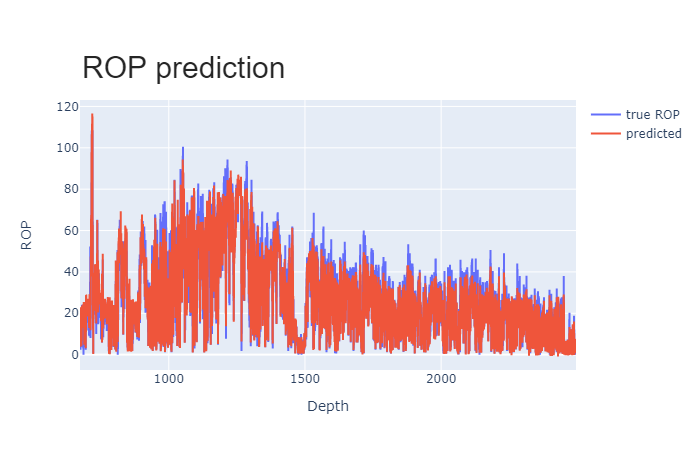

In [60]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter( x=depth_,y=rop_,
                    mode='lines',
                    name='true ROP'))
fig.add_trace(go.Scatter(y=pred_, x=depth_,
                    mode='lines',
                    name='predicted'))
# Title
fig.update_layout(
    annotations=annotations,
    yaxis=dict(title='ROP '),
    xaxis=dict(title='Depth'),
    width=1200
)

fig.show('png')

Text(0, 0.5, 'MSE')

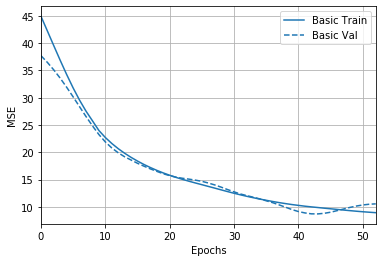

In [57]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = 'mse')    
plt.ylabel('MSE')

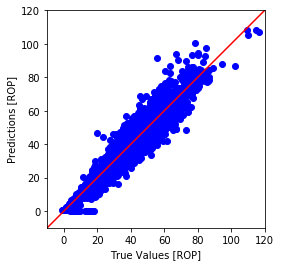

In [58]:
graph(pred_, rop_)

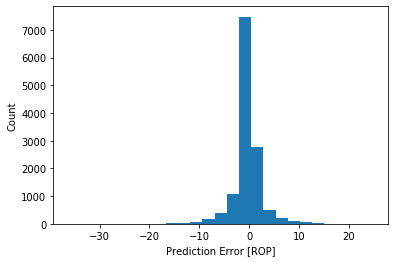

In [59]:
error = pred_ - rop_
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [ROP]")
_ = plt.ylabel("Count")

# accuracy: 96.68%